Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE".

Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All). On JupyterLab, you may want to hit the "Validate" button as well.

Caution: do not mess with the notebook's metadata; do not change a pre-existing cell's type; do not copy pre-existing cells (add new ones with the + button instead). This will break autograding; you will get a 0; you are warned.

<table style="width: 100%; border: none;" cellspacing="0" cellpadding="0" border="0">
  <tr>
    <td><img src="https://www.planetegrandesecoles.com/wp-content/uploads/2021/07/Identite%CC%81-visuelle-Plane%CC%80te-BAC-8-600x398.png" style="float: left; width: 100%" />
</td>
    <td><a style="font-size: 3em; text-align: center; vertical-align: middle;" href="https://moodle.polytechnique.fr/course/view.php?id=19260">[CSC2S004EP - 2024] - Introduction to Machine Learning</a>
</td>
  </tr>
</table>

<a style="font-size: 3em;">Lab Session 09: Dimensionality Reduction with Principal Components Analysis (PCA)</a>

J.B. Scoggins - Adrien Ehrhardt

# Introduction

In this lab, you will get hands-on experience with dimension reduction using Principal Component Analysis. The goal of dimension reduction is to find a suitable transformation which converts a high-dimensional space into a smaller feature space, such that the important information is not lost, but the visualization and interpretability are easier.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn import decomposition
from sklearn import datasets

import tensorflow.keras.datasets.fashion_mnist as mnist
import tensorflow as tf
from tensorflow.keras.layers import Flatten, Dense, Input, BatchNormalization
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential

# Step 1: The Fashion MNIST Dataset

We will use the Fashion MNIST digits dataset throughout this lab session. The original MNIST dataset provides 60000 28x28 pixel grayscale [images of fashion items from 10 categories that can be found here](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/fashion_mnist/load_data). The images are labeled with integer values 0-9. The training set has become the _de facto_ image classification example due to its small size.

In this exercise, we are not interested in classifying images of digits. Instead, we will think of the images as defining a 28x28 = 784 element feature space. In this context, we are interested in transforming the 784 parameters into a smaller set of transformed coordinates.  

**Exercise 1.1:** Before continuing to the next section, use the keras datasets module (look at the imports above...) to load the MNIST dataset, normalize it, and get to know how it is structured.

In [2]:
# x_train, ..., = mnist...  # <- TO UNCOMMENT AND COMPLETE
# x_train = x_train / ...   # <- TO UNCOMMENT AND COMPLETE
# YOUR CODE HERE
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

- Inspect the dataset. What is the shape of x_train and y_train and why?

In [3]:
# YOUR CODE HERE
print("Training data shape:", x_train.shape)
print("Training labels shape:", y_train.shape)
print("Test data shape:", x_test.shape)
print("Test labels shape:", y_test.shape)

Training data shape: (60000, 28, 28)
Training labels shape: (60000,)
Test data shape: (10000, 28, 28)
Test labels shape: (10000,)


- Plot a few images using `matplotlib.pyplot` to see what they look like (remember `imshow` ?).

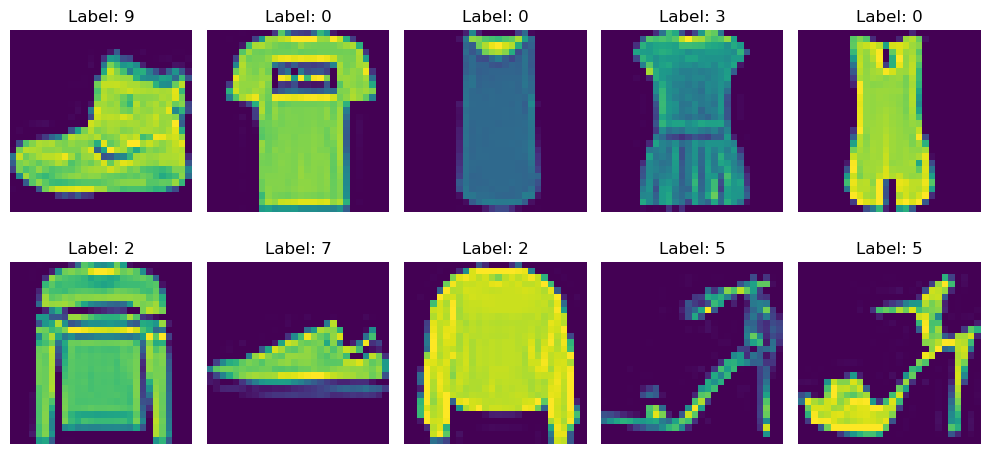

In [4]:
# YOUR CODE HERE
def plot_mnist_images(images, labels, rows=2, cols=5):
    
    plt.figure(figsize=(10, 5))
    for i in range(10):
        plt.subplot(2, 5, i+1)
        plt.imshow(x_train[i])
        plt.title(f"Label: {y_train[i]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_mnist_images(x_train, y_train)

## Step 2: Principal Component Analysis (PCA)

The goal of PCA is to perform an orthogonal transformation which converts a set of observations of possibly correlated variables into a set of values of linearly uncorrelated variables, called _principal components_. This can be thought of as fitting a $p$-dimensional ellipsoid to the observations.  

Let's consider a dataset $X\in \mathbb{R}^{n\times p}$, where $n$ is the number of observations and $p$ the number of variables.  PCA transforms $X$ into a new coordinate system (new variable set), such that the greatest variance in the data is captured in the first coordinate, and then the second, and so on.  More specifically, the transformed coordinates $T \in \mathbb{R}^{n\times p}$ are written as a linear combination of the original dataset,

$$ T = X W, $$

where $W \in \mathbb{R}^{p\times p}$ is the transformation matrix. The first column of $W$, denoted as $w_1$, is constructed to maximize the variance of the transformed coordinates.

$$ w_1 = \underset{\|w\|=1}{\operatorname{argmax}} \sum_{i=1}^{n} (t_1)_i^2 = \underset{\|w\|=1}{\operatorname{argmax}} \| X w \|_2^2 = \underset{\|w\|=1}{\operatorname{argmax}} \frac{w^T X^T X w}{w^T w} $$

The ratio in the last term is known as the _Rayleigh quotient_. It is well known that for the positive, semidefinite matrix $X^T X$, the largest value of the Rayleigh quotient is given as the largest eigenvalue of the matrix, where $w$ is the eigenvector associated with that eigenvalue.

The remaining columns of $W$ can be found by finding the next orthogonal linear combination which maximizes the variance of the data, minus the previously transformed coordinates.

$$ w_k = \underset{\|w\|=1}{\operatorname{argmax}} \| (X - \sum_{s=1}^{k-1} X w_s w_s^T) w \|^2_2 $$

Practically, the columns of $W$ are typically computed as the eigenvectors of $X^T X$ ordered by their corresponding eigenvalues in descending order.

### Singular Value Decomposition

The Singular Value Decomposition of a matrix $X \in \mathbb{R}^{n\times p}$ is given as

$$ X = U \Sigma W^T, $$

where $\Sigma \in \mathbb{R}^{n\times p}$ is a rectangular diagonal matrix of positive values known as the singular values of $X$ (often denoted by $\sigma(X)$), and $U \in \mathbb{R}^{n\times n}$ and $W \in \mathbb{R}^{p\times p}$ are orthonormal matrices, which columns are the left and right (respectively) singular vectors of the matrix $X$. Using this decomposition, we can easily see that

$$ X^T X = W \hat{\Sigma} W^T, $$

where $\hat{\Sigma}$ is a square diagonal matrix of the squared singular values of $X$. Comparing this to the eigenvalue decomposition of $X^T X = Q \Lambda Q^T$ (where $Q$ is the square $p \times p$ matrix which columns correspond to eigenvectors of $X^T X$, and $\Lambda$ is the diagonal matrix which diagonal elements are the corresponding eigenvalues), we see that the singular values of $X$ represent the square-root of the eigenvalues of $X^T X$, and the singular vectors of $X$ are simply the eigenvectors of $X^T X$.  Therefore, we can perform PCA on a data matrix $X$ by computing its right singular vector matrix, $W$.

### Dimensionality Reduction

We can reduce the dimensionality of our data by truncating the transformed variables to include only a subset of those variables with the highest variance. For example, if we keep the first $L \leq p$ variables, the reduced transformation reads

$$ T_L = X W_L, $$

where $W_L \in \mathbb{R}^{n\times L}$ is the eigenvector matrix as before, but taking only the first $L$ columns.  This technique has been widely used to reduce the dimension of large-dimensioned datasets by accounting for the directions of largest variance in the data, while neglecting the other directions. In addition, this can also be used to remove noise from a dataset, in which it is assumed that the noise accounts for a small degree of variance, compared to the true underlying parameterization. Finally, using PCA to find the 2 (resp. 3) highest varying parameters can also allow us to visualize in 2D (resp. 3D) a high-dimensional dataset.

### An example with `sklearn` to get you started: the `iris` dataset

Loading the iris dataset:

In [5]:
iris = datasets.load_iris()
X = iris.data
y = iris.target
print("Shape of X:", X.shape, "\n")
print("The 4 features are:", iris.feature_names, "\n")
smpl = np.random.randint(0, X.shape[0], size=10)
print("10 random rows of X:")
print(X[smpl, :], "\n")
print("Their associated label:")
print(y[smpl], "\n")
print("The label names associated to 0, 1 and 2 resp.")
print(iris.target_names)

Shape of X: (150, 4) 

The 4 features are: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)'] 

10 random rows of X:
[[5.7 3.8 1.7 0.3]
 [6.4 3.2 4.5 1.5]
 [5.7 2.9 4.2 1.3]
 [6.3 2.5 4.9 1.5]
 [5.4 3.9 1.3 0.4]
 [5.  3.6 1.4 0.2]
 [6.9 3.1 4.9 1.5]
 [5.8 2.6 4.  1.2]
 [6.7 3.3 5.7 2.1]
 [5.1 2.5 3.  1.1]] 

Their associated label:
[0 1 1 1 0 0 1 1 2 1] 

The label names associated to 0, 1 and 2 resp.
['setosa' 'versicolor' 'virginica']


Let's visualize the two first coordinates and the labels.

Would we be able to directly predict the labels, *i.e.* draw linear decision boundaries for each class?

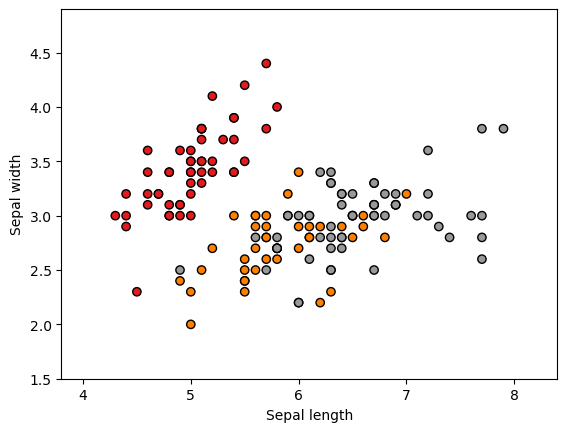

In [6]:
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Set1, edgecolor='k')
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.show()

... No, not really; let's try in 3D:

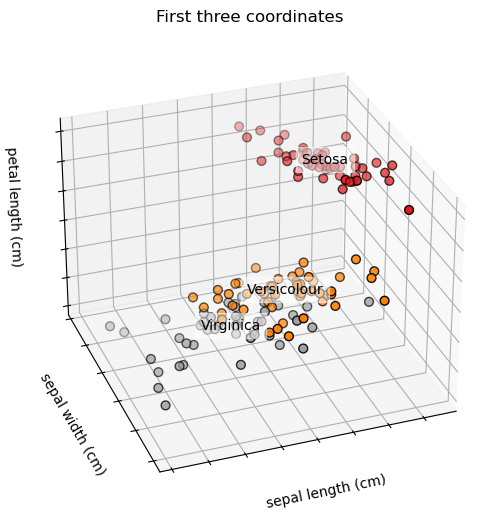

In [7]:
fig = plt.figure()
ax = Axes3D(fig, elev=-150, azim=110)
fig.add_axes(ax)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y,
           cmap=plt.cm.Set1, edgecolor='k', s=40)
ax.set_title("First three coordinates")
ax.set_xlabel(iris.feature_names[0])
ax.xaxis.set_ticklabels([])
ax.set_ylabel(iris.feature_names[1])
ax.yaxis.set_ticklabels([])
ax.set_zlabel(iris.feature_names[2])
ax.zaxis.set_ticklabels([])
for name, label in [('Setosa', 0), ('Versicolour', 1), ('Virginica', 2)]:
    ax.text3D(X[y == label, 0].mean(),
              X[y == label, 1].mean(),
              X[y == label, 2].mean(),
              name,
              horizontalalignment='center',
              bbox=dict(alpha=.5, edgecolor='w', facecolor='w'))

The setosa are well apart, but not the other two classes. Unfortunately, it would be hard to represent a 4D graph... So that's where PCA comes in handy!

Let's perform PCA with `sklearn` and represent the data projected unto the 3 first axes (hence $L=3$ in the equation above).

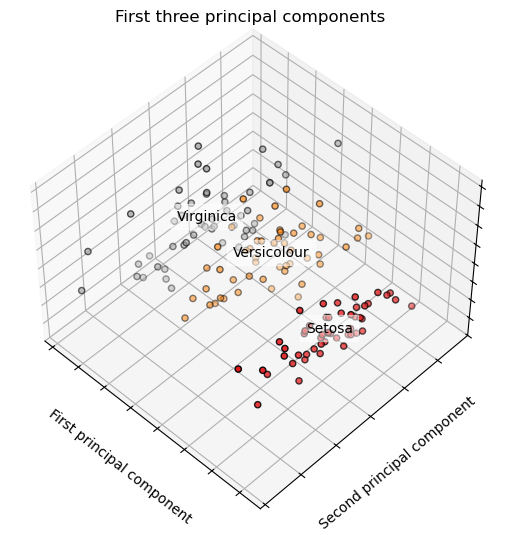

In [8]:
fig = plt.figure()
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
fig.add_axes(ax)

plt.cla()
pca = decomposition.PCA(n_components=3)
pca.fit(X)
X_transformed = pca.transform(X)

ax.set_title("First three principal components")
ax.set_xlabel("First principal component")
ax.xaxis.set_ticklabels([])
ax.set_ylabel("Second principal component")
ax.yaxis.set_ticklabels([])
ax.set_zlabel("Third principal component")
ax.zaxis.set_ticklabels([])

for name, label in [('Setosa', 0), ('Versicolour', 1), ('Virginica', 2)]:
    ax.text3D(X_transformed[y == label, 0].mean(),
              X_transformed[y == label, 1].mean(),
              X_transformed[y == label, 2].mean(), name,
              horizontalalignment='center',
              bbox=dict(alpha=.5, edgecolor='w', facecolor='w'))

ax.scatter(X_transformed[:, 0], X_transformed[:, 1], X_transformed[:, 2], 
           c=y, cmap=plt.cm.Set1,
           edgecolor='k')

ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.zaxis.set_ticklabels([])

plt.show()

The 3 types of flowers seem well separated. Is it also the case in 2D now (hence $L=2$ in the equation above)?

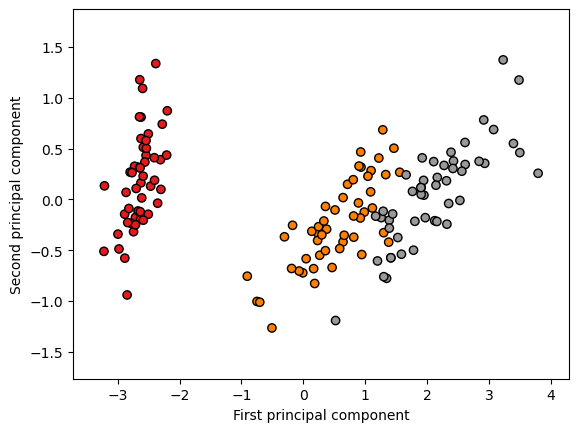

In [9]:
x_min, x_max = X_transformed[:, 0].min() - .5, X_transformed[:, 0].max() + .5
y_min, y_max = X_transformed[:, 1].min() - .5, X_transformed[:, 1].max() + .5

plt.scatter(X_transformed[:, 0], 
            X_transformed[:, 1], 
            c=y, 
            cmap=plt.cm.Set1,
            edgecolor='k')
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max);

Perfect! It seems we were able to "compress" enough information from the 4 original features into 2 linear combinations of these features: the two first principal components. Let's look at their definition:

In [10]:
pd.DataFrame(data=pca.components_,
             columns=iris.feature_names,
             index=["1st PC", "2nd PC", "3rd PC"])

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
1st PC,0.361387,-0.084523,0.856671,0.358289
2nd PC,0.656589,0.730161,-0.173373,-0.075481
3rd PC,-0.582030,0.597911,0.076236,0.545831


Let's look at the fraction of explained variance:

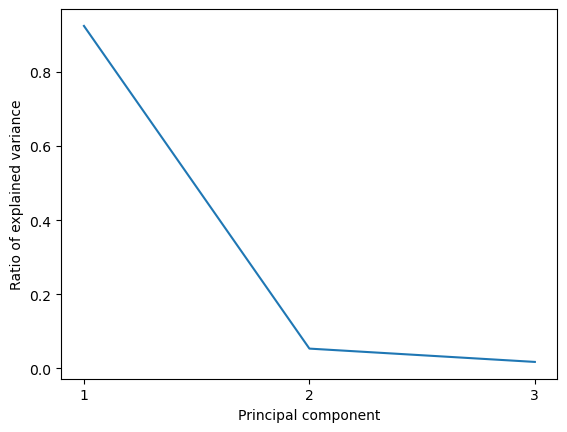

In [11]:
plt.plot(range(1, 4), pca.explained_variance_ratio_)
plt.xlabel('Principal component')
plt.ylabel('Ratio of explained variance')
plt.xticks([1, 2, 3])
plt.show()

### The real deal: the `MNIST` dataset

**Exercise 2.1:** Visualize the MNIST dataset in 2 dimensions.

- Reshape the array `x_train` to 2D with n = 60000 and p = 28 x 28 = 784.

In [12]:
# x_train_reshaped = ...  # <- TO UNCOMMENT AND COMPLETE
# YOUR CODE HERE
x_train_reshaped = x_train.reshape(60000, 784)

- Use numpy to [compute the reduced SVD](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.svd.html) of the MNIST images. Recall the notations of $U$, $\Sigma$ and $W^T$ [introduced above](#Step-2:-Principal-Component-Analysis-(PCA)). (Yes, this might take some time... If you get a `MemoryError`, read the documentation carefully).

In [13]:
# u, sigma, w_transpose = ...  # <- TO UNCOMMENT AND COMPLETE
# YOUR CODE HERE
u, sigma, w_transpose = np.linalg.svd(x_train_reshaped, full_matrices=False)  

- Compute the first two principal components by truncating the eigenvector matrix (*i.e.* the two first columns of $W$, denoted by $W_2$ in the [notations introduced above](#Step-2:-Principal-Component-Analysis-(PCA))).
- Multiply the original data by the previous result (*i.e.* the the two first principal components): you obtain the projected data (onto the new PCA space), in other words $T_L$ for $L=2$ in the [notations introduced above](#Step-2:-Principal-Component-Analysis-(PCA)).

In [14]:
# T_2 = ...  # <- TO UNCOMMENT AND COMPLETE
# YOUR CODE HERE
w_2 = w_transpose.T[:, :2]
T_2 = np.dot(x_train_reshaped, w_2)

- Plot the original data projected onto the two first principal components using a scatter plot with [`matplotlib.pyplot.scatter`](https://matplotlib.org/3.5.0/api/_as_gen/matplotlib.pyplot.scatter.html), and the image labels to color the markers.

(*Hint*: the plot might be easier to interpret if you represent fewer points)

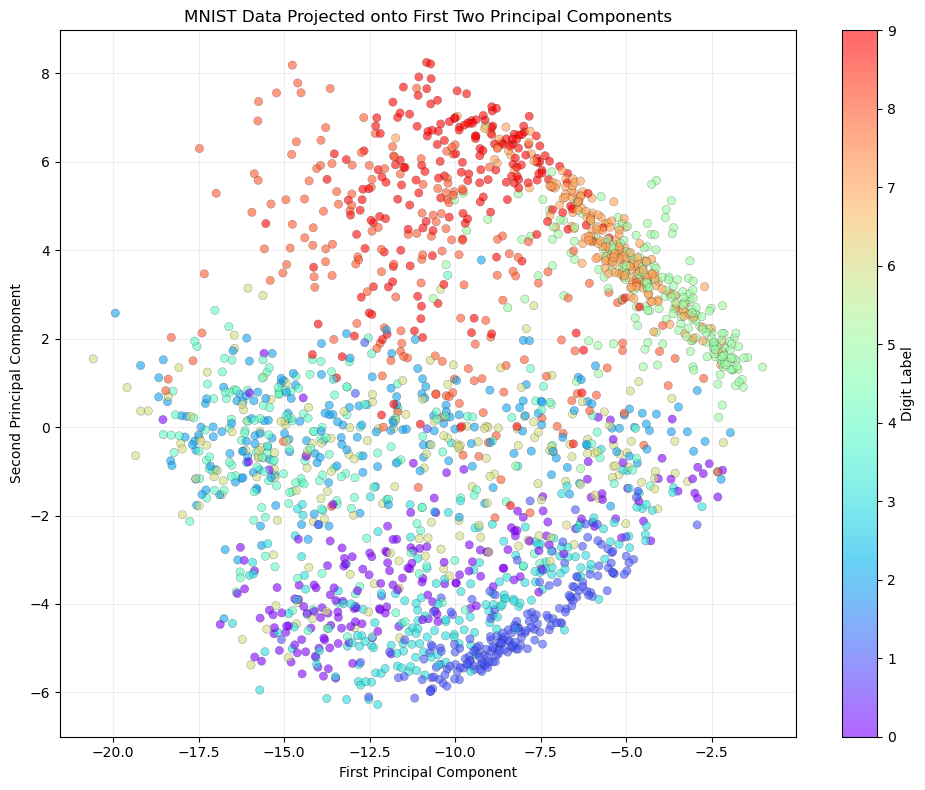

In [17]:
# plt.scatter(..., cmap='rainbow')  # <- TO UNCOMMENT AND COMPLETE
# YOUR CODE HERE

# Plot a subset of the data (1000 random samples) for better visualization
np.random.seed(0)  
indices = np.random.choice(T_2.shape[0], 2000, replace=False)
sampled_data = T_2[indices]
sampled_labels = y_train[indices]

plt.figure(figsize=(10, 8))
scatter = plt.scatter(sampled_data[:, 0], 
                      sampled_data[:, 1], 
                      c=sampled_labels, 
                      cmap='rainbow', 
                      alpha=0.6,
                      edgecolor='k',
                      linewidth=0.2)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('MNIST Data Projected onto First Two Principal Components')
plt.colorbar(scatter, label='Digit Label', ticks=range(10))
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()
#plt.colorbar();

- What do you notice about how the data is presented in the plot?

We observe clustering for similar digits. Some class separation is lost when compressing to 2d.

- Which images form a tight cluster in the reduced space?

The images that form tight cluster are trousers and bags.

### Scree Plot

It is not always clear how many principal components are necessary to accurately represent the high-dimensional space.  There are two widely used methods to help us get a sense of the number variables required. The first is called a Scree plot, which plots the **eigenvalues** of $X^T X$ in descending order. Since the eigenvalues represent the degree of variance in the corresponding principal components, such a plot can tell use how many components are needed before we reach diminishing returns.

**Exercise 2.2:** Plot the Scree plot for the MNIST data. _Hint_: use the `sigma` matrix of **singular** values of $X$ computed above.

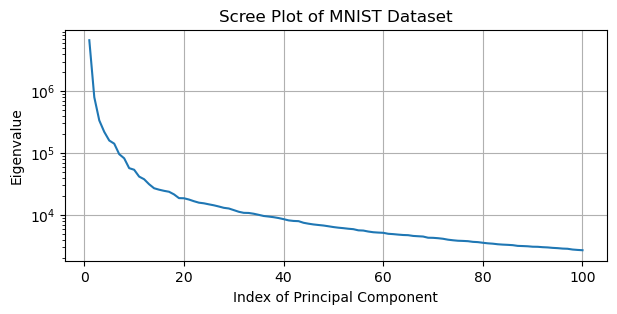

In [49]:
# YOUR CODE HERE
eigenvalues = sigma*sigma
x_axis = np.arange(1,101)
plt.figure(figsize=(7,3))
plt.plot(x_axis, eigenvalues[:100])
plt.title('Scree Plot of MNIST Dataset')
plt.xlabel('Index of Principal Component')
plt.ylabel('Eigenvalue')
plt.yscale('log') 
plt.grid(True)
plt.show()

- How many principal components are needed to represent most of the variance.

In [33]:
# n_principal_components_on_scree_plot = ...  # TO UNCOMMENT AND COMPLETE

# YOUR CODE HERE
n_principal_components_on_scree_plot = 20

### Total Variance Explained

Another method is called _Total Variance Explained_.  In this method, we plot the cumulative sum of the eigenvalues and choose the number of components which give us a certain percentage fo the total variance.

**Exercise 2.3:** Plot the cumulative sum of the eigenvalues.
- Plot a horizontal line at 95% of the total sum.

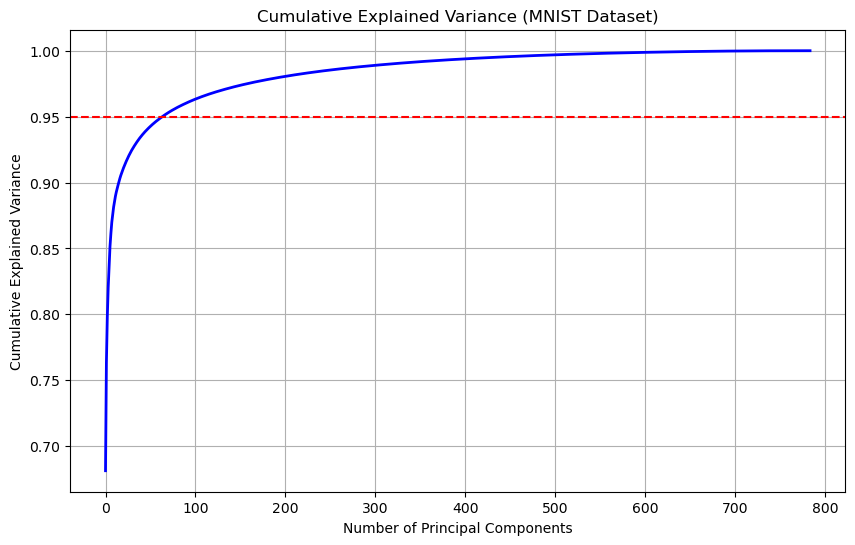

In [34]:
# YOUR CODE HERE
explained_variance = np.square(sigma) / np.square(sigma).sum()
cumulative_variance = np.cumsum(explained_variance)

# Plot cumulative variance with 95% threshold
plt.figure(figsize=(10, 6))
plt.plot(cumulative_variance, 'b-', linewidth=2)
plt.axhline(y=0.95, color='r', linestyle='--', linewidth=1.5)
plt.title('Cumulative Explained Variance (MNIST Dataset)')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

- Based on this, how many components are needed to capture 95% of the variance?

In [35]:
# n_principal_components_on_total_variance = ...  # TO UNCOMMENT AND COMPLETE

# YOUR CODE HERE
n_principal_components_on_total_variance = np.argmax(cumulative_variance >= 0.95) + 1
print(f"Components needed for 95% variance: {n_principal_components_on_total_variance}")

Components needed for 95% variance: 65


- How does this compare to the Scree plot result?

The difference between the two numbers is important.

### Reconstruct Images

Now that we have an idea of how many principal components are necessary, let's use them to encode the images in a smaller set of features, which we can then decode to reconstruct the images from the lower-dimensional space.  Recall that based on the PCA transformation, we can compute the reconstructed images with

$$ \hat{X} = X W_L W_L^T $$

**Exercise 2.4:** Plot original and reconstruct images.
- Create a grid of images using `pyplot.subplots` and `imshow`.
  - In the first row, plot the first 5 images of the dataset.
  - In the next 4 rows, plot reconstructions of the images using the first 5, 15, 30, and 100 principal component vectors.
- How do the reconstructed images compare with the originals as you increase the size of the reduced space?

Note that once we have computed the transformation matrix $W$, we essentially have a compression scheme to convert our images into a compressed format.  From this perspective, using the first 5, 10, 30, and 100 principal components is equivalent to compressing the data at a rate of 156:1, 78:1, 26:1, and 8:1, respectively.  By contrast, JPEG image compression can obtain compression ratios of 23:1 with reasonable image quality, surpassing the quality of reconstructions with PCA.  For that reason, PCA is not really used for image compression, but it has been used in a number of other fields, particularly in physics and engineering.


In [36]:
def plot_original_and_reconstructed(file_name: str = None):
    # Plot some sample reconstructions next to originals
    fig, ax = plt.subplots(5, 5)
    W = w_transpose.T
    for i in range(5):
        # Originals
        ax[0, i].imshow(x_train[i, :])
        ax[0, i].set_axis_off()
        for j, s in enumerate([5, 15, 30, 100]):
            # Reconstruct x_train[i, :] with only s principal components
            # reconstructed_x_train_i_with_s_pc = ...
            # YOUR CODE HERE
            W_L = W[:, :s]
            W_L_T = W_L.T
            X_reduced = np.dot(x_train[i, :].reshape(1, 784), W_L)  
            reconstructed_x_train_i_with_s_pc = np.dot(X_reduced, W_L_T)

            ax[j + 1, i].imshow(reconstructed_x_train_i_with_s_pc.reshape(28, 28))
            ax[j + 1, i].set_axis_off()
    if file_name is not None:
        plt.savefig(file_name)

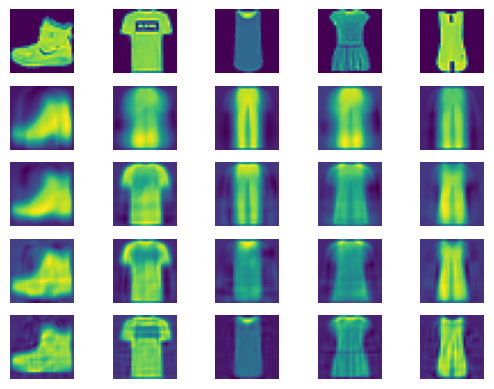

In [37]:
plot_original_and_reconstructed()

### Before the Autoencoder... Discrete Cosine Transform (DCT)

The [Discrete Cosine Transform (DCT)](https://en.wikipedia.org/wiki/Discrete_cosine_transform) is a linear transformation in a fixed (!= learned) basis of cosine functions. Its strength relies in the fact that the result of the projection is sparse (many entries close to 0). Let's investigate:

In [38]:
from scipy.fftpack import dct, idct

In [39]:
def image_dct(image):
    """
    Apply 2D DCT on an image
    """
    return dct(dct(image.T, norm="ortho").T, norm="ortho")

In [40]:
def image_idct(image):
    """
    Apply inverse 2D DCT on an image projected using DCT
    """
    return idct(idct(image.T, norm="ortho").T, norm="ortho")

Let's try that on the first image:

In [41]:
# DCT
image2 = image_dct(x_train[0, :, :])

In [42]:
image2.shape

(28, 28)

In [43]:
# Inverse DCT
image3 = image_idct(image2)

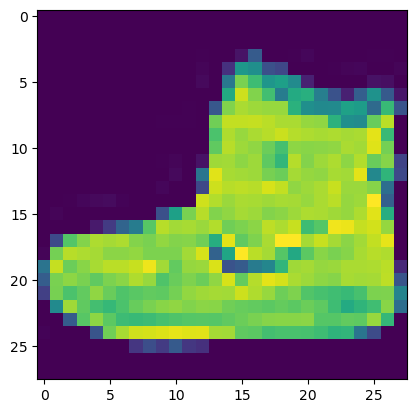

In [44]:
# We applied a transformation, than its inverse; there is no loss, we get the original image back
plt.imshow(image3);

Apply the DCT transformation to all images in `x_train` and put the result in `x_train_jpg`.

In [45]:
# x_train_jpg = ...  # TO UNCOMMENT AND COMPLETE

# YOUR CODE HERE
x_train_jpg = np.zeros_like(x_train)

for i in range(len(x_train)):
    x_train_jpg[i] = image_dct(x_train[i])

print(x_train_jpg.shape)

(60000, 28, 28)


Remove all entries of each image in `x_train_jpg` which absolute value is less than 2 % of the maximum value in all images of `x_train_jpg`.

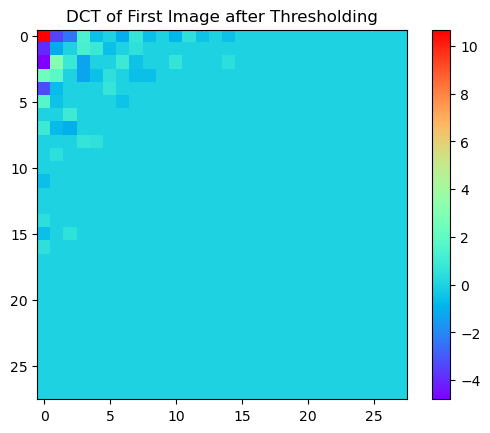

In [46]:
# x_train_jpg = ...  # TO UNCOMMENT AND COMPLETE

# YOUR CODE HERE
global_max = np.max(np.abs(x_train_jpg))

threshold = 0.02 * global_max

x_train_jpg[np.abs(x_train_jpg) < threshold] = 0


plt.imshow(x_train_jpg[0], cmap='rainbow')
plt.colorbar()
plt.title('DCT of First Image after Thresholding')
plt.show()

How many entries were discarded (this corresponds to the compression rate)?

In [47]:
print(f"Entries exactly 0: {100 * np.sum(x_train_jpg == 0.0) / np.prod(x_train_jpg.shape):.2f} %")

Entries exactly 0: 95.12 %


Is the reconstruction any good?

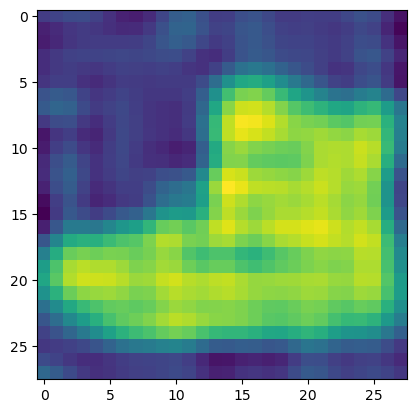

In [48]:
plt.imshow(image_idct(x_train_jpg[0, :, :]));